In [111]:
%load_ext pretty_jupyter

The pretty_jupyter extension is already loaded. To reload it, use:
  %reload_ext pretty_jupyter


In [112]:
# -.-|m { input: false, output: false, input_fold: show}

import tomlkit
import scanpy as sc
import anndata as ad
from scipy.stats import median_abs_deviation

import numpy as np
import pandas as pd
import requests

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc_context
import patchworklib as pw
import seaborn.objects as so

from typing import List, Dict, Callable
from anndata import AnnData

from IPython.display import display
import session_info
import logging

logging.basicConfig(level=logging.ERROR)


In [113]:
# Configs
## Utility Functions
def get_sample_name(file_path: str, black_list: list[str], n = 3):
    from os import path
    """"Function to return probable sample name from a path, it recurselvy goes through the path and returns the first element not in the black list."""
    if n == 0:
        return ""

    tmp = path.basename(file_path)
    _d = path.dirname(file_path)

    if all(entry not in tmp for entry in black_list):
        return tmp
    else:
        res = get_sample_name(_d, black_list, n-1)
    return res


def is_outlier(adata: AnnData, metric: str, nmads: int):
    
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


def read_parsebio(data_path: str):
    """Reads ParseBio

    Args:
        data_path (str): _description_

    Returns:
        _type_: _description_
    """    

    adata = sc.read_mtx(data_path + 'count_matrix.mtx')

    # reading in gene and cell data
    gene_data = pd.read_csv(data_path + 'all_genes.csv')
    cell_meta = pd.read_csv(data_path + 'cell_metadata.csv')

    # find genes with nan values and filter
    gene_data = gene_data[gene_data.gene_name.notnull()]
    notNa = gene_data.index
    notNa = notNa.to_list()

    # remove genes with nan values and assign gene names
    adata = adata[:,notNa]
    adata.var = gene_data
    adata.var.set_index('gene_name', inplace=True)
    adata.var.index.name = None
    adata.var_names_make_unique()

    # add cell meta data to anndata object
    adata.obs = cell_meta
    adata.obs.set_index('bc_wells', inplace=True)
    adata.obs.index.name = None
    adata.obs_names_make_unique()

    return adata



def human2mouse(genes: List[str]) -> List[str]:

    r = requests.post(
        url='https://biit.cs.ut.ee/gprofiler/api/orth/orth/',
        json={
            'organism':'hsapiens',
            'target':'mmusculus',
            'query':genes,
        }
        )
    df = pd.DataFrame(r.json()['result'], )
    return df.name.replace("N/A", pd.NA).dropna().to_list()




In [114]:
## Technology components

inputs: Dict[str, List|Callable] = {
          "10x":{
                 "files": ['features.tsv.gz', 'barcodes.tsv.gz', 'matrix.mtx.gz'],
                 "black_list": ["filtered_feature_bc", "raw_feature_bc", "count"],
                 "raw_name": "raw_feature_bc_matrix",
                 "function": sc.read_10x_mtx
                 },

          "ParseBio":{
                    "files": ["all_genes.csv", "cell_metadata.csv", "count_matrix.mtx"],
                    "black_list": ["DGE_filtered", "DGE_unfiltered"],
                    "function": read_parsebio
                    }
          }


qc_features_fac: Dict[str, List[str]] = {"human": {
                         "mito": ["MT-"],
                         "ribo": ["RBS", "RPL"],
                         "hb": ["^HB[^(P)]"]
                         },
               "mouse": {
                        "mito": ["mt"],
                        "ribo": ["Rps", "Rpl"],
                        "hb": ["^Hb[^(p)]"] # Validate this later
               }
                         }



In [115]:
## Pipeline parameters

with open("../../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [116]:
DIR_samples = config["basic"]["DIR_SAMPLES"] 
TECHNOLOGY: str = config["basic"]["TECHNOLOGY"]
ORGANISM: str = config["basic"]["ORGANISM"]
AUTODISCOVER: bool = config["basic"]["auto_find"]
samples: Dict[str, str] = config["basic"]["samples"]

CONCAT_SAMPLES: bool = config["QC"]["CONCAT_SAMPLES"]
NMADS: int = config["QC"]["NMADS"]
NMADS_MITO: int = config["QC"]["NMADS_MITO"]
CORRECT_AMBIENT_RNA = config["QC"]["CORRECT_AMBIENT_RNA"]
FILTER_DOUBLETS: bool = config["QC"]["FILTER_DOUBLETS"]
REGRESS: bool = config["QC"]["REGRESS"]
CELL_CYCLE_SCORE: bool = config["QC"]["FILTER_DOUBLETS"]
VARS_TO_REGRESS: List[str]|None = config["QC"]["VARS_TO_REGRESS"] 

sample_components = inputs[TECHNOLOGY]["files"]
black_list = inputs[TECHNOLOGY]["black_list"]
read_function = inputs[TECHNOLOGY]["function"]
raw_name = inputs[TECHNOLOGY]["raw_name"]


In [118]:
# -.-|m { input: false, output: false, input_fold: show}
## Over-ride Pipeline parameters
"in the following cell, override the default pipeline parameters if needed"


'in the following cell, override the default pipeline parameters if needed'

In [119]:
# Diagnosic pipeline
## Reading files

from os import walk, path, listdir

if AUTODISCOVER and len(samples) == 0:
    files = walk(DIR_samples)
    for root, dir, files in files:
        if len(set(sample_components).difference(set(files))) == 0 and path.basename(root) != raw_name:
            samples[get_sample_name(root, black_list, 5)] = root
else:
    samples = config["basic"]["samples"]
    if len(samples) > 0:
        pass
    else:
        raise RuntimeError("No samples paths were provided, provide sample paths as a dictionary in 'config.toml'")


In [121]:
adatas = {}
raw_h5 = {}
for sample_id, filename in samples.items():
    sample_adata = read_function(filename)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

if TECHNOLOGY == "10x":
    for sample_id, filename in samples.items():
        files = listdir(path.dirname(filename))
        raw_file = [file for file in files if "raw_feature_bc_matrix" in file]
        if len(raw_file) == 1:
            adata_raw = sc.read_10x_h5(path.join(path.dirname(filename), raw_file[0]))
        else:
            raise ValueError("No/Multiple raw files meeting condition were found")

        adata_raw.var_names_make_unique()
        raw_h5[sample_id] = adata_raw


if CONCAT_SAMPLES:
    adata = ad.concat(adatas, label="sample", join="outer", merge="same")
    adata.obs_names_make_unique()
    del samples

if CONCAT_SAMPLES and TECHNOLOGY == "10x":
    adata_raw = ad.concat(raw_h5, label="sample", join="outer", merge="same")
    adata_raw.obs_names_make_unique()
    del raw_h5


In [122]:
## Adding quality metrics


"""**TODO:**
- [ ] Handle also multple samples at once
- [ ] Make the Oulier function parameterized on sample
"""


mt_features = qc_features_fac[ORGANISM]["mito"]
rb_features = qc_features_fac[ORGANISM]["ribo"]
hb_features = qc_features_fac[ORGANISM]["hb"]


# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith(tuple(mt_features))
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(tuple(rb_features))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains(tuple(hb_features)[0]) #Only regex is accepted

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], percent_top=[20],  inplace=True, log1p=True
)


In [123]:
#TODO: Add additional Critera for filtering based on Absolute thresholds, can it be per sample?

adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", NMADS)
    | is_outlier(adata, "log1p_n_genes_by_counts", NMADS)
    | is_outlier(adata, "pct_counts_in_top_20_genes", NMADS)
)

adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", NMADS_MITO) 

In [124]:
## Ambient RNA correction
## TODO: Check if the Ambient RNA can be improved by using Batch information?

if CORRECT_AMBIENT_RNA and TECHNOLOGY == "10x":

    from os import system, remove, path
    import tempfile

    with tempfile.TemporaryDirectory(dir=".") as tmpdirname:
        # Define paths for temporary files
        sce_path = path.join(tmpdirname, "sce.h5ad")
        raw_path = path.join(tmpdirname, "raw.h5ad")
        decontx_path = path.join(tmpdirname, "decontX.h5ad")
        
        # Save adata and adata_raw to the temporary directory
        adata.write_h5ad(sce_path)
        adata_raw.write_h5ad(raw_path)
        
        # Execute R scripts with temporary file paths
        system(f"Rscript ./deconx.R -s {sce_path} -r {raw_path} -o {decontx_path}")

        # Read the result back from the temporary directory
        adata = sc.read_h5ad(decontx_path)

All specified packages are already installed.
--------------------------------------------------
Starting DecontX
--------------------------------------------------
Thu Jun  6 18:39:59 2024 .. Analyzing all cells
Thu Jun  6 18:39:59 2024 .... Generating UMAP and estimating cell types
Found more than one class "dist" in cache; using the first, from namespace 'spam'
Also defined by ‘BiocGenerics’
Found more than one class "dist" in cache; using the first, from namespace 'spam'
Also defined by ‘BiocGenerics’
Found more than one class "dist" in cache; using the first, from namespace 'spam'
Also defined by ‘BiocGenerics’
Thu Jun  6 18:40:23 2024 .... Estimating contamination
Thu Jun  6 18:40:27 2024 ...... Completed iteration: 10 | converge: 0.02447
Thu Jun  6 18:40:29 2024 ...... Completed iteration: 20 | converge: 0.006867
Thu Jun  6 18:40:32 2024 ...... Completed iteration: 30 | converge: 0.002888
Thu Jun  6 18:40:35 2024 ...... Completed iteration: 40 | converge: 0.001394
Thu Jun  6 18:

In [125]:
## Doublet Detection

#TODO: Check real-life performance
#TODO: Check Interop with R to convert object to R & vice-versa 
if FILTER_DOUBLETS:
    sc.pp.scrublet(adata, batch_key="sample")

In [126]:
## Cell cycle Scoring
# **Not reliable, do via interop later**

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)


if CELL_CYCLE_SCORE:
    if ORGANISM in ["human", "mouse"]:

        s_genes = [x.strip() for x in open('../Resources/s_genes.txt')]
        g2m_genes = [x.strip() for x in open('../Resources/s_genes.txt')]


        if ORGANISM == "mouse":
            s_genes = human2mouse(s_genes)
            g2m_genes = human2mouse(g2m_genes)


        # Cell cycle scoring is not reliable and not similair to Seurat
        sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
    else:
        logging.error('Organism must be either human or mouse.')

# Quality Plots

In [127]:
# sc.set_figure_params(dpi=300, color_map="viridis_r")
# sc.settings.verbosity = 0

## Basic QC plots & metrics

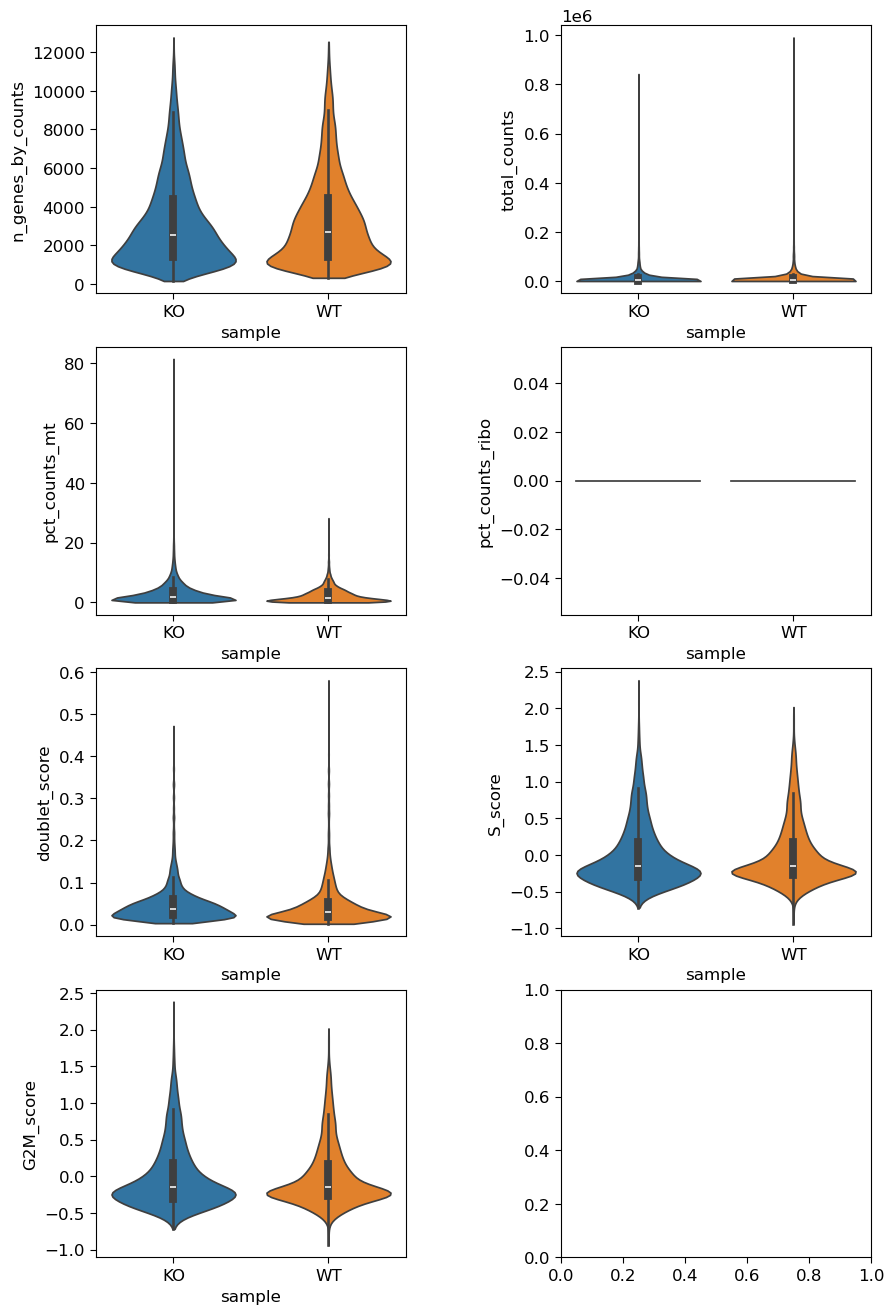

In [128]:
keys = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]

if FILTER_DOUBLETS:
    keys = keys + ["doublet_score"]

if CELL_CYCLE_SCORE:
    keys = keys + ["S_score", "G2M_score"]

ncols = 2
nrows = len(keys) // ncols + len(keys) % ncols


figsize = 4
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)

plt.subplots_adjust(wspace=wspace)
# Prevent the subplots from showing 
plt.close(fig)


for i, key in enumerate(keys):
    row = i // ncols
    col = i % ncols
    sc.pl.violin(adata, keys=[key], groupby="sample", stripplot=False, inner="box", ax=axs[row, col])

display(fig)


### Table of basic QC metrics

In [129]:
df1 = adata.obs.groupby("sample")[keys].agg(["mean", "median"]).round(3)
df2 = adata.obs.groupby("sample")[["sample"]].agg(["size"])
pd.concat([df1, df2], axis =1)

n_genes_by_counts         total_counts         pct_counts_mt         \
                    mean  median         mean  median          mean median   
sample                                                                       
KO              3193.389  2561.0    14489.261  5980.0         3.160  1.877   
WT              3272.712  2674.0    15085.768  6799.0         2.417  1.591   

       pct_counts_ribo        doublet_score        S_score        G2M_score  \
                  mean median          mean median    mean median      mean   
sample                                                                        
KO                 0.0    0.0         0.049  0.037  -0.005 -0.149    -0.005   
WT                 0.0    0.0         0.045  0.029   0.003 -0.148     0.003   

              sample  
       median   size  
sample                
KO     -0.149   8365  
WT     -0.148  11229

## Histograms




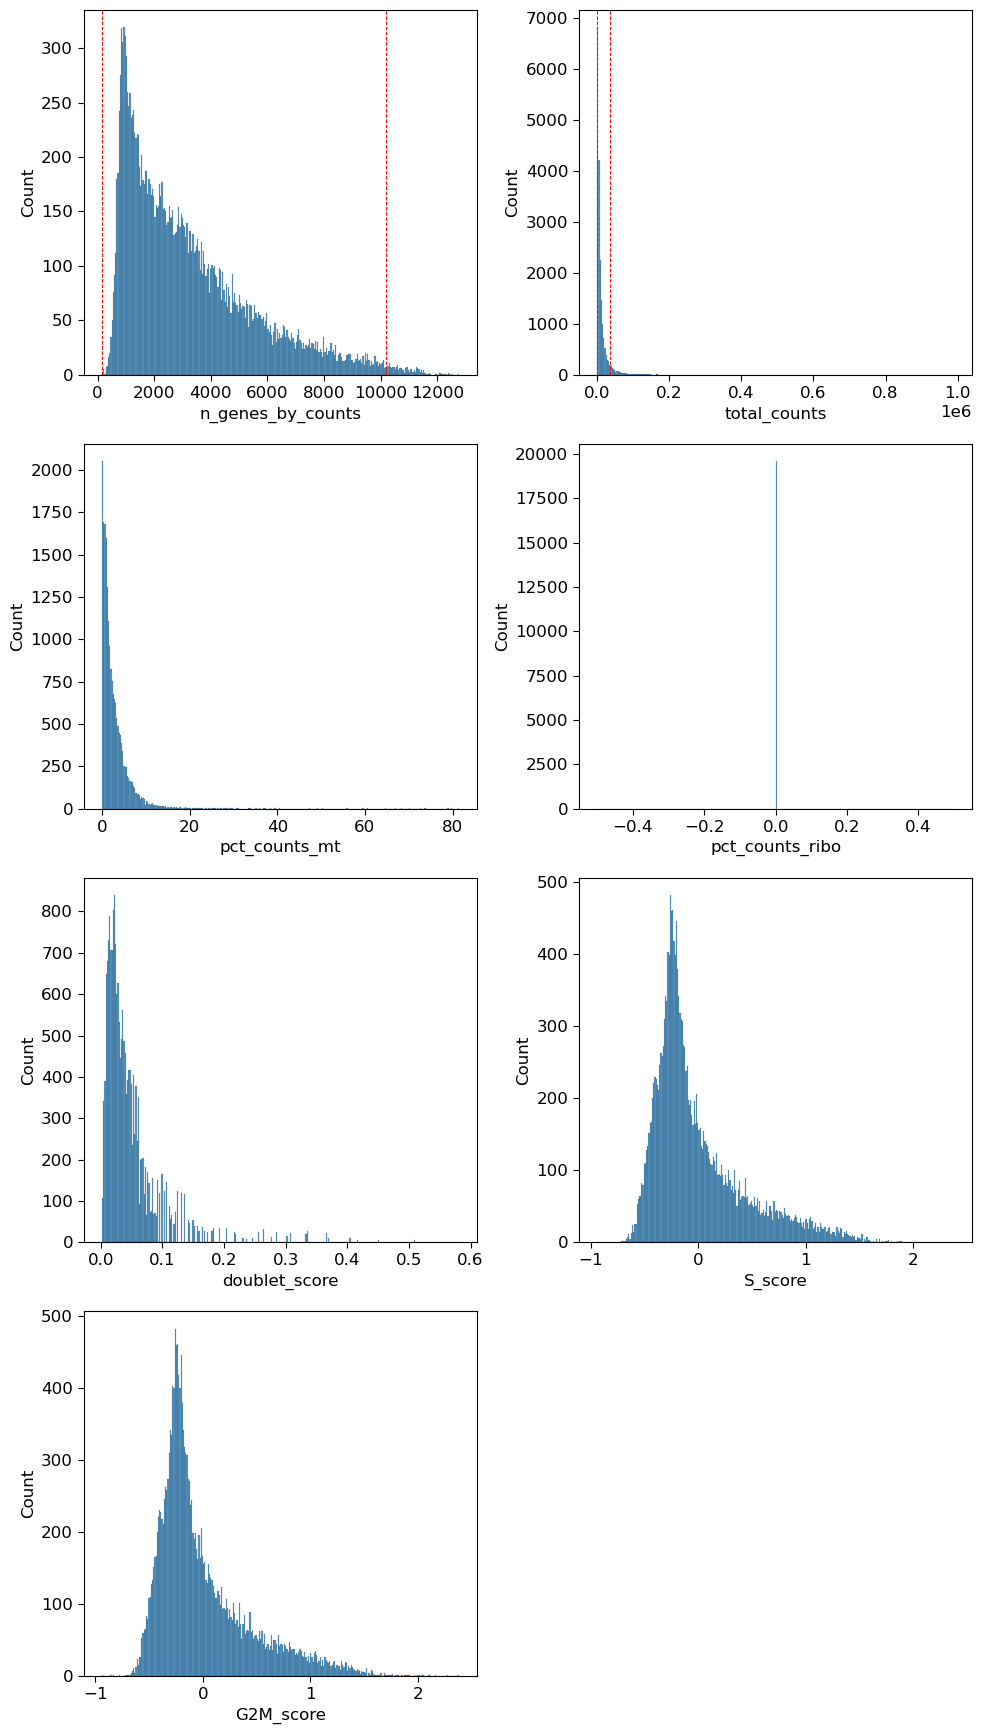

In [130]:
# Assuming 'df' is your DataFrame
df = adata.obs[keys]

# Determine the number of rows and columns for your subplot grid
n = len(df.columns)
ncols = 2
nrows = n // ncols + (n % ncols > 0)

# Create the subplots
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize + wspace * (nrows - 1) ),
)

plt.subplots_adjust(wspace=wspace, hspace=wspace)

# Flatten the axes
axs = axs.flatten()

outlier_dict = {}


# Plot a histogram on each subplot
for i, col in enumerate(df.columns):
    sns.histplot(data=df, x=col, ax=axs[i], bins=300)

    if col in ["n_genes_by_counts", "total_counts"]:
        max_line = min(df[col].agg("mean")+ median_abs_deviation(df[col]) * NMADS,  df[col].agg("max")) 
        min_line = max(df[col].agg("mean") - median_abs_deviation(df[col]) * NMADS, df[col].agg("min"))
        axs[i].axvline(x=max_line, color='red', linestyle='--', linewidth = 0.7)
        axs[i].axvline(x=min_line, color='red', linestyle='--', linewidth = 0.7)

        outlier_dict[col] = (min_line, max_line)

    if col is "pct_counts_mt":
        max_line = min(df[col].agg("mean")+ median_abs_deviation(df[col]) * NMADS_MITO,  df[col].agg("max")) 
        min_line = max(df[col].agg("mean") - median_abs_deviation(df[col]) * NMADS_MITO, df[col].agg("min"))
        axs[i].axvline(x=max_line, color='red', linestyle='--', linewidth = 0.7)
        axs[i].axvline(x=min_line, color='red', linestyle='--', linewidth = 0.7)

        outlier_dict[col] = (min_line, max_line)

# Remove any unused subplots
if len(df.columns) < nrows*ncols:
    for i in range(len(df.columns), nrows*ncols):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


# ax1 = pw.Brick(figsize=(3,2))
# ax2 = pw.Brick(figsize=(3,2))
# ax3 = pw.Brick(figsize=(3,2))
# ax4 = pw.Brick(figsize=(3,2))


# sns.histplot(data=adata.obs, x="total_counts", hue="sample", bins=300, ax = ax1)
# sns.histplot(data=adata.obs, x="n_genes_by_counts", hue="sample", bins=300, ax = ax2)
# sns.histplot(data=adata.obs, x="pct_counts_ribo", hue="sample", bins=300, ax = ax3)
# sns.histplot(data=adata.obs, x="pct_counts_mt", hue="sample", bins=300, ax = ax4)


# for ax in [ax1, ax2, ax3, ax4]:
#     ax.move_legend(new_loc='upper left', bbox_to_anchor=(1.05, 1.0))
#     legend = ax.legend_
#     for t in legend.get_texts():
#         t.set_fontsize(8)

# combined = (ax1+ax2)/(ax3+ax4)
# display(combined)


In [131]:
manual_filters = {}

## Filtering Thresholds

In [132]:
pd.DataFrame(outlier_dict, index= ("Min", "Max")).T

,Min,Max
n_genes_by_counts,155.0,10186.347402
total_counts,1059.0,35071.109421


## Number of outliers based on provided criteria

In [133]:
df1 = pd.DataFrame(adata.obs[["outlier", "mt_outlier", "sample"]].value_counts(subset=["outlier",  "sample"]))
df2 = pd.DataFrame(adata.obs[["outlier", "mt_outlier", "sample"]].value_counts(subset=["mt_outlier",  "sample"]))

df1.columns = ["Outlier"]
df2.columns = ["MT-Outlier"]

pd.concat([df1,df2], axis=1)

Outlier  MT-Outlier
      sample                     
False WT         8429       10040
      KO         7051        7010
True  WT         2800        1189
      KO         1314        1355

## Remaining Cells after filtering based on outlier function

In [134]:
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

In [135]:
df1 = adata.obs.groupby("sample")[keys].agg(["mean", "median"]).round(3)
df2 = adata.obs.groupby("sample")[["sample"]].agg(["size"])
pd.concat([df1, df2], axis =1)

n_genes_by_counts         total_counts         pct_counts_mt         \
                    mean  median         mean  median          mean median   
sample                                                                       
KO              3418.461  2866.0    12968.836  5597.0         2.128  1.813   
WT              3792.106  3361.0    13962.100  6637.0         2.248  1.979   

       pct_counts_ribo        doublet_score        S_score        G2M_score  \
                  mean median          mean median    mean median      mean   
sample                                                                        
KO                 0.0    0.0         0.049  0.039  -0.015 -0.157    -0.015   
WT                 0.0    0.0         0.049  0.034   0.033 -0.099     0.033   

              sample  
       median   size  
sample                
KO     -0.157   5739  
WT     -0.099   7248

## Scatter plots of confounders

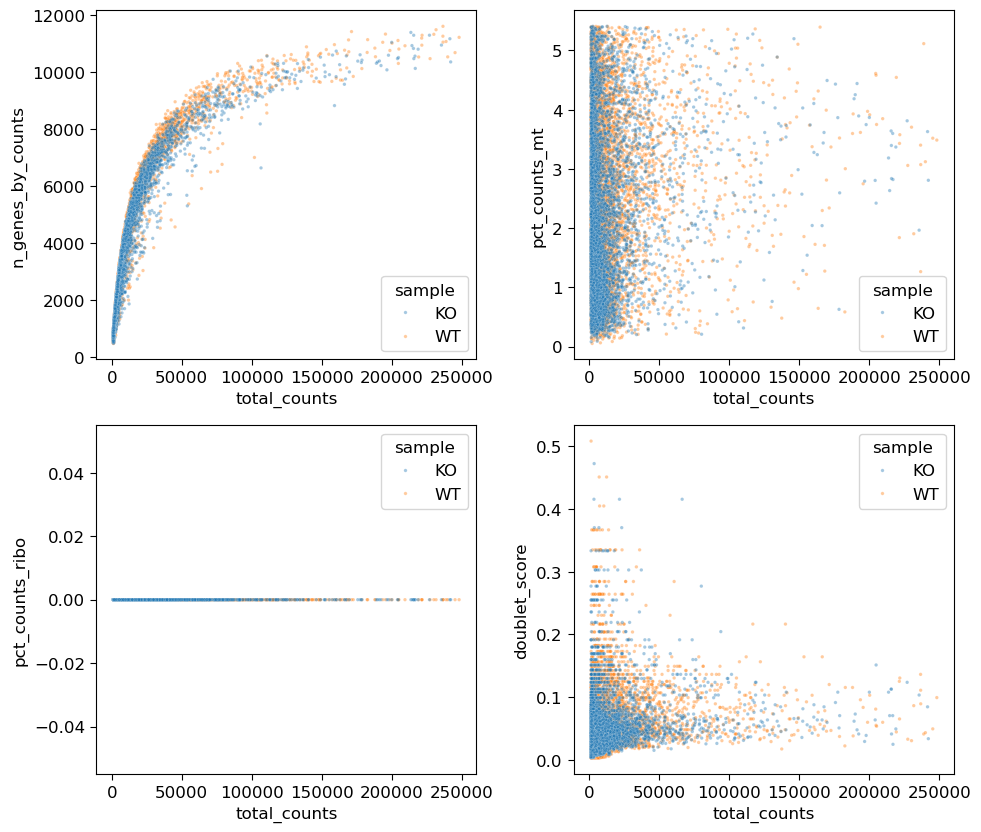

In [136]:
# Assuming 'df' is your DataFrame
df = adata.obs[keys+["sample"]]

# Determine the number of rows and columns for your subplot grid
n = len(df.columns)
ncols = 2
nrows = 2
figsize= 4

# Create the subplots
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize + wspace * (nrows - 1) ),
)

plt.subplots_adjust(wspace=wspace, hspace=wspace)

# Flatten the axes
axs = axs.flatten()

sns.scatterplot(df, x="total_counts", y="n_genes_by_counts", hue = "sample", alpha = 0.4, s = 6,  ax= axs[0])
sns.scatterplot(df, x="total_counts", y="pct_counts_mt", hue = "sample", alpha = 0.4, s = 6,  ax= axs[1])
sns.scatterplot(df, x="total_counts", y="pct_counts_ribo", hue = "sample", alpha = 0.4, s = 6,  ax= axs[2])

if FILTER_DOUBLETS:
    sns.scatterplot(df, x="total_counts", y="doublet_score", hue = "sample", alpha = 0.4, s = 6,  ax= axs[3])

plt.tight_layout()
plt.show()




# display(
#     so.Plot(adata.obs, x="total_counts", y="pct_counts_mt", color = "sample")
#     .add(so.Dot(pointsize=5, alpha=0.4))
# )


# display(
#     so.Plot(adata.obs, x="total_counts", y="pct_counts_ribo", color = "sample")
#     .add(so.Dot(pointsize=5, alpha=0.4))
# )

# if FILTER_DOUBLETS:
#     display(so.Plot(adata.obs, x="total_counts", y="doublet_score", color = "sample")
#     .add(so.Dot(pointsize=5, alpha=0.4))
#     )


## DecontX contamination

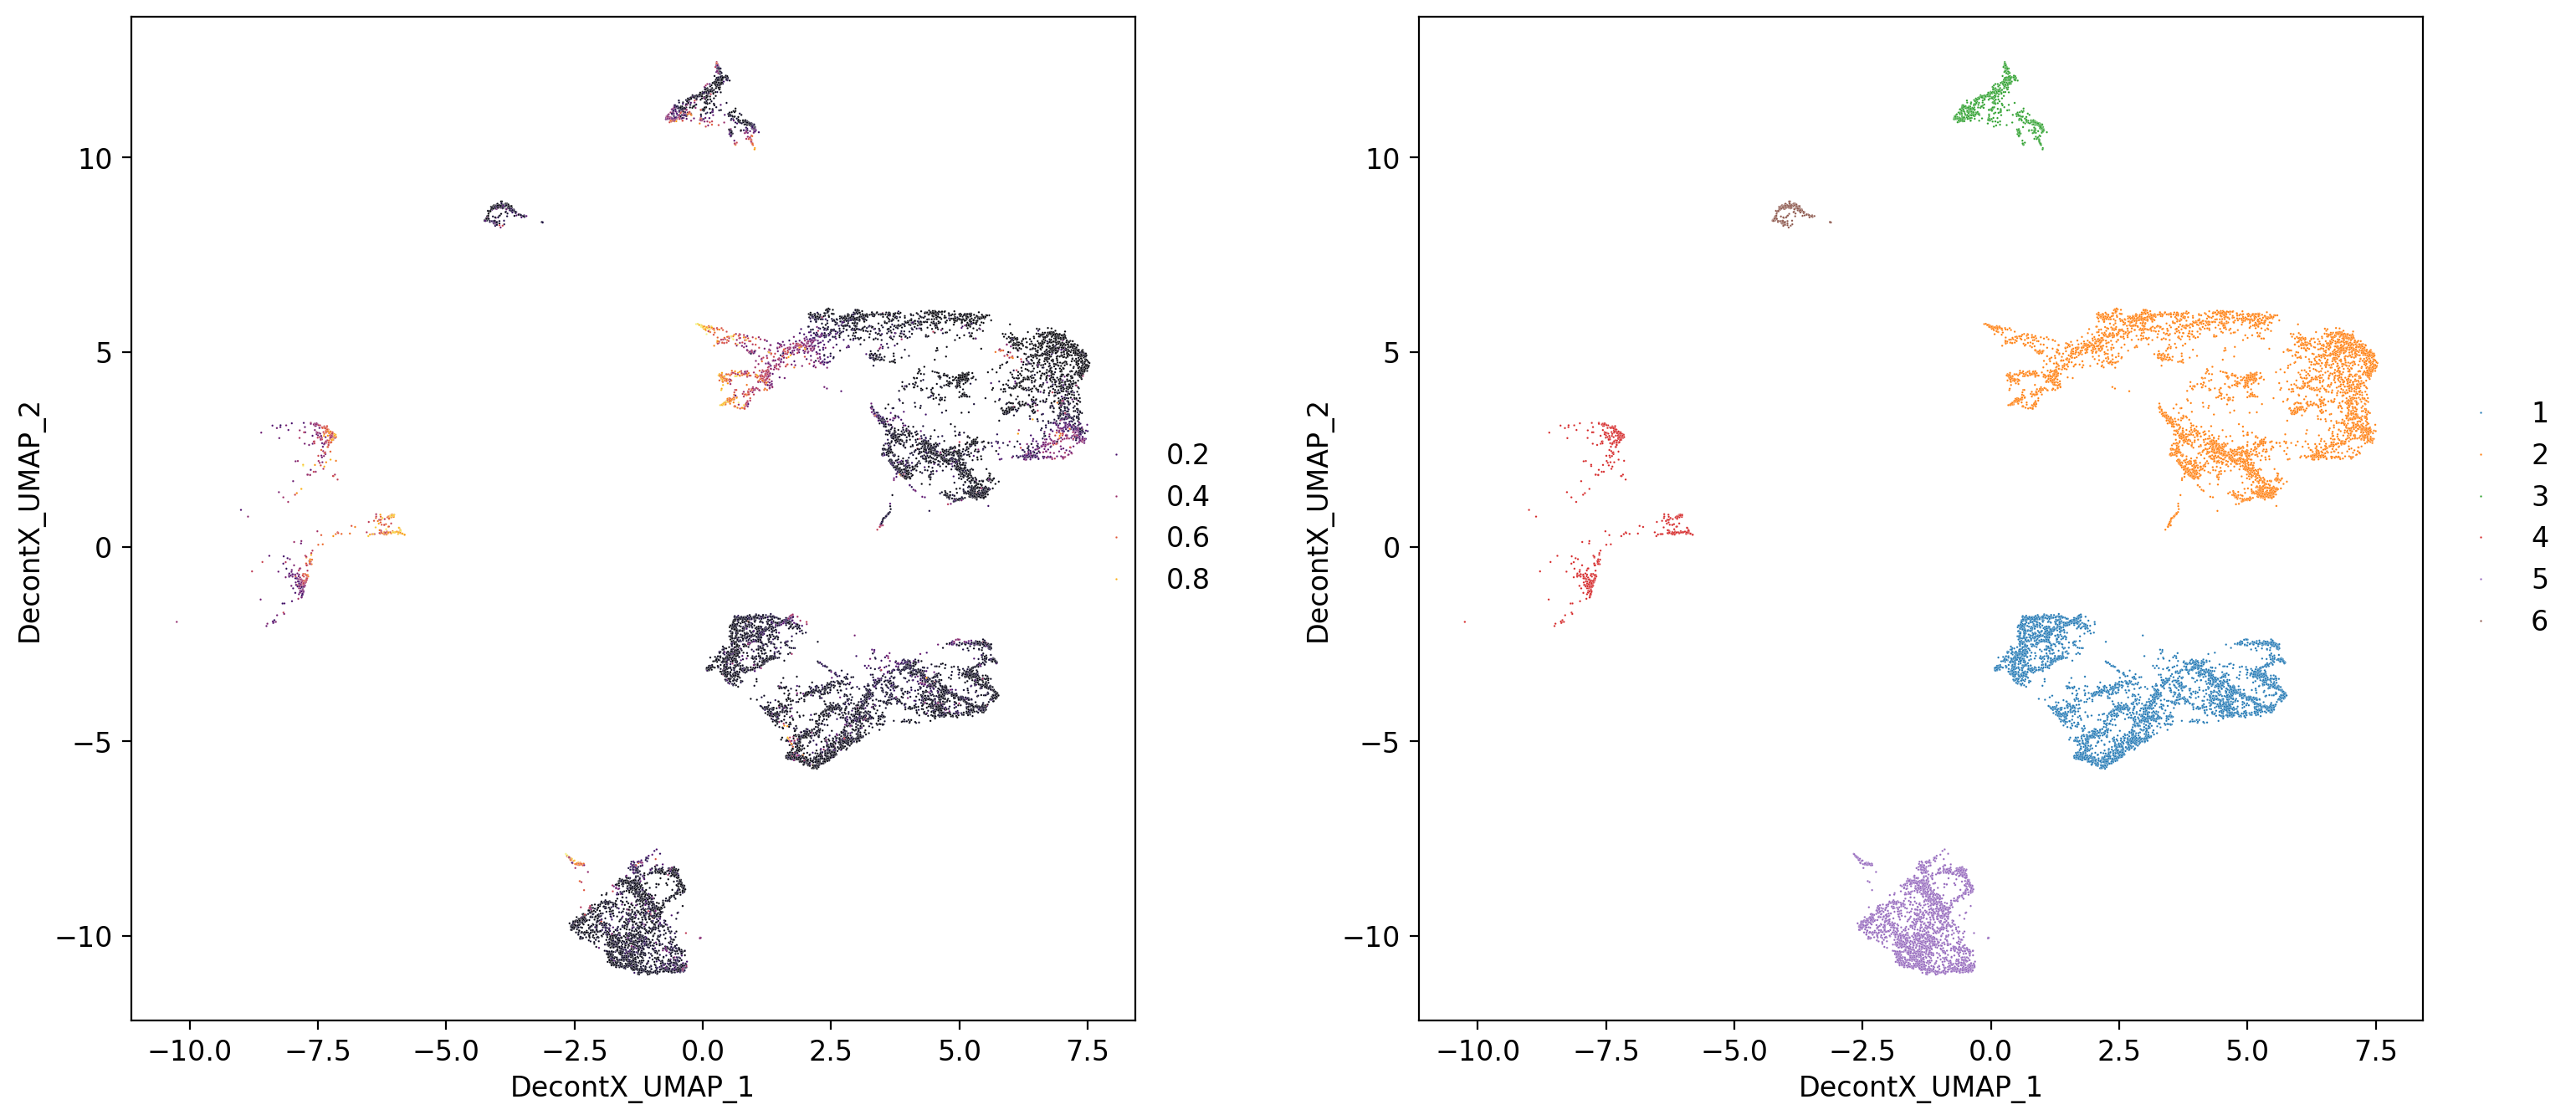

In [137]:

if CORRECT_AMBIENT_RNA and TECHNOLOGY == "10x":
    ax1 = pw.Brick(figsize=(6,6))
    ax2 = pw.Brick(figsize=(6,6))

    scatter = sns.scatterplot(pd.concat([adata.obsm["decontX_UMAP"], adata.obs], axis = 1), x = "DecontX_UMAP_1", y = "DecontX_UMAP_2", hue= "decontX_contamination" , s= 0.8, ax = ax1, palette="inferno")
    sns.move_legend(scatter, "center right", bbox_to_anchor=(1.1, 0.5), title=None, frameon=False)

    scatter = sns.scatterplot(pd.concat([adata.obsm["decontX_UMAP"], adata.obs], axis = 1), x = "DecontX_UMAP_1", y = "DecontX_UMAP_2", hue= "decontX_clusters" , s= 0.8, ax=ax2)
    sns.move_legend(scatter, "center right", bbox_to_anchor=(1.15, 0.5), title=None, frameon=False)

    ax12 = ax1+ax2
    display(ax12)

## Clustering prior to cell filtering

In [138]:
sc.pp.pca(adata, n_comps=20)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added="groups", flavor="igraph")
sc.tl.umap(adata)

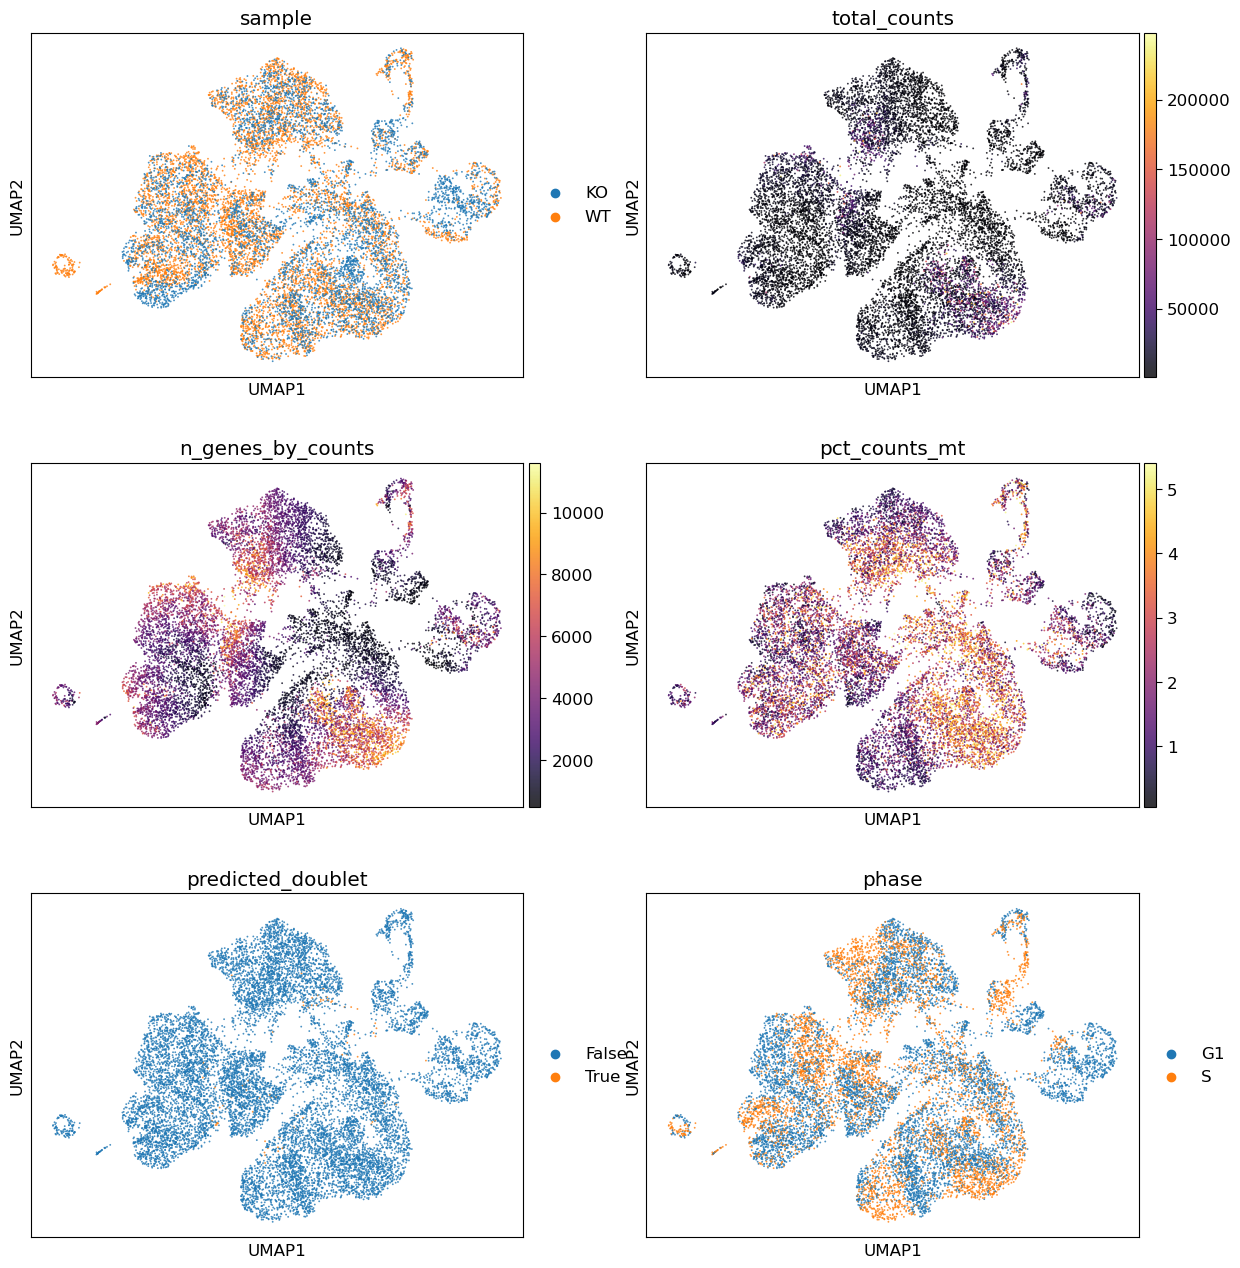

In [139]:
# -.-|m { input: false, output: true, input_fold: show}
keys = ["sample", "total_counts", "n_genes_by_counts", "pct_counts_mt"]

if FILTER_DOUBLETS:
    keys = keys + ["predicted_doublet"]

if CELL_CYCLE_SCORE:
    keys = keys + ["phase"]

figs = sc.pl.umap(adata, size= 7, color= keys, show=False, ncols = 2, color_map="inferno", sort_order=False, alpha = 0.8)

# Regression of Variables

In [140]:
# - [ ] Add error handling if the vars to regress is empty or contain non-keys
if REGRESS:
    sc.pp.regress_out(adata, keys= VARS_TO_REGRESS)

In [170]:
adata.obs

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,...,decontX_contamination,decontX_clusters,n_genes,doublet_score,predicted_doublet,n_counts,S_score,G2M_score,phase,groups
AAACAAGCAATGAGCCAACGGGAA-1,WT,2957,7.992269,5382.0,8.591002,8.286882,76.0,4.343805,1.412115,0.0,...,0.013997,1,2957,0.033079,False,5382.0,0.708197,0.708197,S,0
AAACAAGCACAGCAACAACGGGAA-1,WT,843,6.738152,2423.0,7.793174,27.445316,10.0,2.397895,0.412712,0.0,...,0.044109,3,843,0.023555,False,2423.0,-0.412892,-0.412892,G1,1
AAACAAGCAGAGGCTTAACGGGAA-1,WT,2261,7.724005,3429.0,8.140316,6.824147,32.0,3.496508,0.933217,0.0,...,0.031528,1,2261,0.018878,False,3429.0,-0.356001,-0.356001,G1,0
AAACAAGCATCGATAGACTTTAGG-1,WT,5243,8.564840,12701.0,9.449514,3.999685,41.0,3.737670,0.322809,0.0,...,0.026544,2,5243,0.014218,False,12701.0,0.733244,0.733244,S,3
AAACAAGCATTGCCCAACTTTAGG-1,WT,3307,8.104099,6492.0,8.778480,10.921134,96.0,4.574711,1.478743,0.0,...,0.037526,1,3307,0.043515,False,6492.0,0.123662,0.123662,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGAGTAGGTGACATGTTGAC-1,KO,5887,8.680672,16686.0,9.722385,7.473331,459.0,6.131227,2.750809,0.0,...,0.069692,2,5887,0.235832,False,16686.0,0.195697,0.195697,S,4
TTTGTGAGTCCACAATATGTTGAC-1,KO,6926,8.843182,26409.0,10.181498,6.232724,439.0,6.086775,1.662312,0.0,...,0.051976,1,6925,0.041409,False,26409.0,-0.138252,-0.138252,G1,8
TTTGTGAGTGAACGGTATGTTGAC-1,KO,4322,8.371705,11396.0,9.341105,12.267462,275.0,5.620401,2.413127,0.0,...,0.154473,1,4322,0.084693,False,11396.0,-0.109296,-0.109296,G1,9
TTTGTGAGTGCTGATTATGTTGAC-1,KO,3852,8.256607,8126.0,9.002947,8.983510,81.0,4.406719,0.996800,0.0,...,0.402884,2,3852,0.169399,False,8126.0,-0.218594,-0.218594,G1,7


# Ambient RNA 

<Axes: xlabel='decontX_clusters', ylabel='decontX_contamination'>

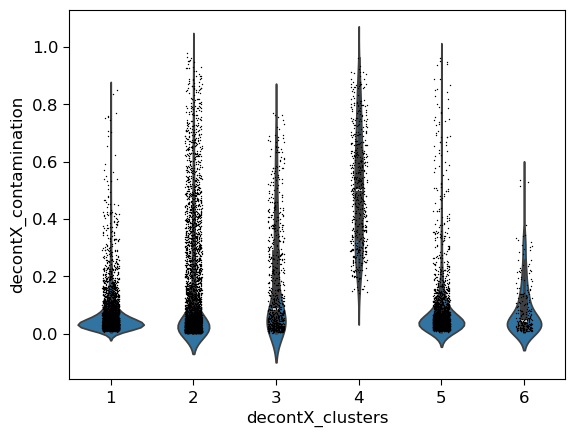

In [173]:
sns.violinplot(adata.obs, x = "decontX_clusters", y = "decontX_contamination")
sns.stripplot(adata.obs, x = "decontX_clusters", y = "decontX_contamination", s = 1, c = "black")


In [ ]:
## Save Result
adata.write_h5ad("adata.h5ad")

# Session Information

In [ ]:
session_info.show()